In [1]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import timm

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tqdm.notebook import tqdm
from PIL import Image

In [2]:
## PYTORCH DATASET

# Dataset class
class FaceExpressionDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data = ImageFolder(data_dir, transform=transform)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]
    
    @property
    def classes(self):
        return self.data.classes

In [7]:
# Transform
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

# Setup Data
train_folder = '/kaggle/input/face-expression-dataset/face-expression/train'
test_folder = '/kaggle/input/face-expression-dataset/face-expression/validation'

train_dataset = FaceExpressionDataset(train_folder, transform=transform)
test_dataset = FaceExpressionDataset(test_folder, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)

# Print classes
target_to_class = {v: k for k, v in ImageFolder(train_folder).class_to_idx.items()}
print(target_to_class)

{0: 'angry', 1: 'disgust', 2: 'fear', 3: 'happy', 4: 'neutral', 5: 'sad', 6: 'surprise'}


In [8]:
## PYTORCH MODEL

# Model class
class ExpressionClassifier(nn.Module):
    # Define parts of the model
    def __init__(self, num_classes):
        super(ExpressionClassifier, self).__init__()
        self.base_model = timm.create_model('efficientnet_b0', pretrained=True)
        self.features = nn.Sequential(*list(self.base_model.children())[:-1])  # Remove additional last layer
        
        enet_out_size = 1280 # Output size of EfficientNet-B0's feature extractor.
        self.classifier = nn.Sequential(
            nn.BatchNorm1d(enet_out_size),
            nn.Dropout(0.5),
            nn.Linear(enet_out_size, num_classes)
        )
    
    # Connect these parts and return output
    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        output = self.classifier(x)
        return output

# Initialize Model
model = ExpressionClassifier(num_classes=7)

In [9]:
## PYTORCH TRAINING LOOP

# Loss fn, optimer, scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

num_epoch = 10
train_losses = []
train_accuracies = []

def calculate_accuracy(output, target):
    _, preds = torch.max(output, 1)
    correct = (preds == target).sum().item()
    return correct / target.size(0)

# Training function
def train(model, train_loader, criterion, optimizer, scheduler, device):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    
    for images, labels in tqdm(train_loader, desc='Training Loop'):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
        running_corrects += (outputs.argmax(dim=1) == labels).sum().item()
        
    scheduler.step()
    
    train_loss = running_loss / len(train_loader.dataset)
    train_accuracy = running_corrects / len(train_loader.dataset)
    
    return train_loss, train_accuracy

# Evaluation function
def evaluate(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc='Validation Loop'):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
            running_corrects += (outputs.argmax(dim=1) == labels).sum().item()
    
    test_loss = running_loss / len(test_loader.dataset)
    test_accuracy = running_corrects / len(test_loader.dataset)
    
    return test_loss, test_accuracy

# Loop
for epoch in range(num_epoch):
    # Train the model
    train_loss, train_accuracy = train(model, train_loader, criterion, optimizer, scheduler, device)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    
    # Print epoch stats for training
    print(f"Epoch {epoch+1}/{num_epoch} - Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}")

# Evaluate the model on the test set
test_loss, test_accuracy = evaluate(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

Training Loop:   0%|          | 0/451 [00:00<?, ?it/s]

Epoch 1/10 - Train Loss: 1.3464, Train Acc: 0.5113


Training Loop:   0%|          | 0/451 [00:00<?, ?it/s]

Epoch 2/10 - Train Loss: 1.0937, Train Acc: 0.5936


Training Loop:   0%|          | 0/451 [00:00<?, ?it/s]

Epoch 3/10 - Train Loss: 0.8984, Train Acc: 0.6656


Training Loop:   0%|          | 0/451 [00:00<?, ?it/s]

Epoch 4/10 - Train Loss: 0.8336, Train Acc: 0.6904


Training Loop:   0%|          | 0/451 [00:00<?, ?it/s]

Epoch 5/10 - Train Loss: 0.7700, Train Acc: 0.7133


Training Loop:   0%|          | 0/451 [00:00<?, ?it/s]

Epoch 6/10 - Train Loss: 0.7602, Train Acc: 0.7149


Training Loop:   0%|          | 0/451 [00:00<?, ?it/s]

Epoch 7/10 - Train Loss: 0.7549, Train Acc: 0.7198


Training Loop:   0%|          | 0/451 [00:00<?, ?it/s]

Epoch 8/10 - Train Loss: 0.7558, Train Acc: 0.7188


Training Loop:   0%|          | 0/451 [00:00<?, ?it/s]

Epoch 9/10 - Train Loss: 0.7495, Train Acc: 0.7189


Training Loop:   0%|          | 0/451 [00:00<?, ?it/s]

Epoch 10/10 - Train Loss: 0.7553, Train Acc: 0.7211


Validation Loop:   0%|          | 0/111 [00:00<?, ?it/s]

Test Loss: 0.8917, Test Accuracy: 0.6790


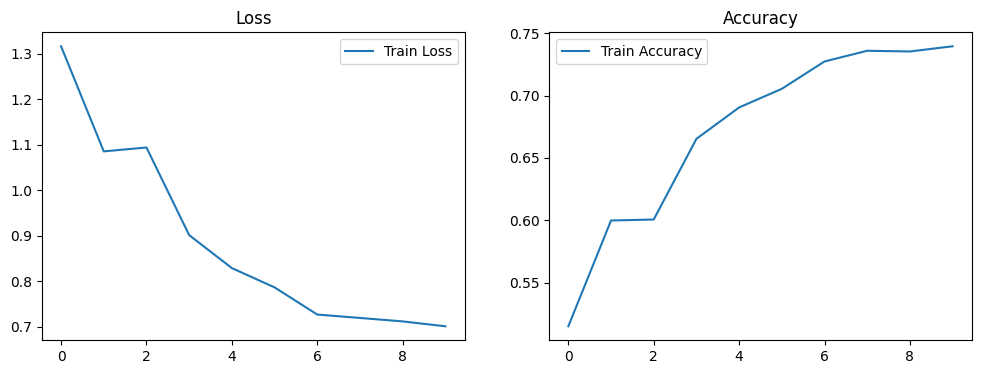

In [22]:
# Plotting the results
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.legend()
plt.title('Accuracy')

plt.show()

# Face Expression Summary
Train accuracy: 71%  
Test accuracy: 67%  

Approach mostly same as dog-breed. Differences mentioned below:

- DataLoader has a `num_workers` parameter to increase CPU utilization, and batch_size increased to 64 to increase GPU utilization. This is for speeding up the training process.
- Adam optimizer has `weight_decay` parameter to implement L2 regularization to reduce overfitting. It is still there idk how else to fix it.